In [ ]:
import sys
sys.path.insert(1, "./")

In [5]:
from utils import *

torch.manual_seed(410)
np.random.seed(410)
random.seed(410)

In [7]:
transform = transforms.Compose([transforms.ToTensor()])
fashion_mnist_train = datasets.FashionMNIST(root='data/', train=True, download=True, transform=transform)
fashion_mnist_val = datasets.FashionMNIST(root='data/', train=False, download=True, transform=transform)

# Customizing FashionMNIST dataset for the siamese network
train_dataset = CustomFashionMNIST(fashion_mnist_train)
val_datset = CustomFashionMNIST(fashion_mnist_val)

In [8]:
class SiameseNet(AbstractSiameseNet):
    def __init__(self, input_size, output_size, layer_width=8):
        super(SiameseNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            # TODO: Define the layers of the Siamese network. Use your best defined model architecture from the previous task but don't include the sigmoid layer.
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(input_size, layer_width), # Layer 1
            nn.ReLU(),
            nn.Linear(layer_width, 64), # Layer 2
            nn.ReLU(),

            nn.Linear(64, output_size) # change to outputsize size
        )

    def forward(self, x1, x2):
        # TODO: Define the forward pass of the Siamese network
        # pass x1 and x2 through self.layers separately ,two separate models being compared together
        out1 = self.layers(x1)
        out2 = self.layers(x2)
        return out1, out2



In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model initialization and summary
model = SiameseNet(input_size=28*28, output_size=10)
summary(model, [(1, 28, 28), (1, 28, 28)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Flatten-2                  [-1, 784]               0
            Linear-3                    [-1, 8]           6,280
              ReLU-4                    [-1, 8]               0
            Linear-5                   [-1, 64]             576
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
           Flatten-8                  [-1, 784]               0
           Flatten-9                  [-1, 784]               0
           Linear-10                    [-1, 8]           6,280
             ReLU-11                    [-1, 8]               0
           Linear-12                   [-1, 64]             576
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [13]:
# Configure hyperparameters
LEARNING_RATE = 0.0001# TODO: use the the learning rate you found achieves the best performance from the previous experiments
EPOCHS = 10
BATCH_SIZE = 64
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0) # TODO: use the optimizer you found achieves the best performance from the previous experiments
loss_function = ContrastiveLoss() # Contrastive loss minimizes the distance between similar pairs and maximizes the distance between dissimilar pairs

100%|██████████| 938/938 [00:20<00:00, 46.66it/s]


Epoch [5], train_loss: 0.3855, train_acc: 0.7344, val_loss: 0.3892, val_acc: 0.7571


100%|██████████| 938/938 [00:19<00:00, 47.51it/s]


Epoch [10], train_loss: 0.3479, train_acc: 0.7538, val_loss: 0.3646, val_acc: 0.7420


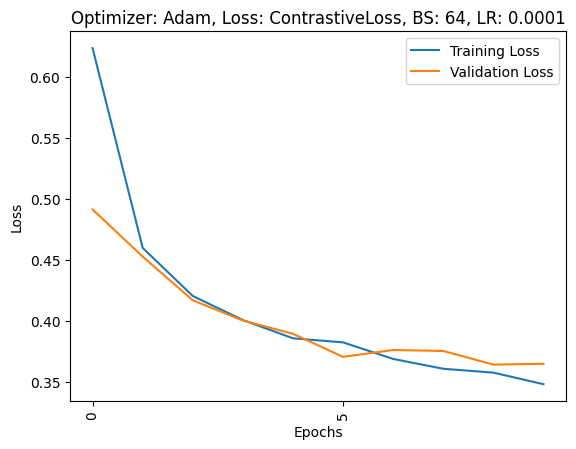

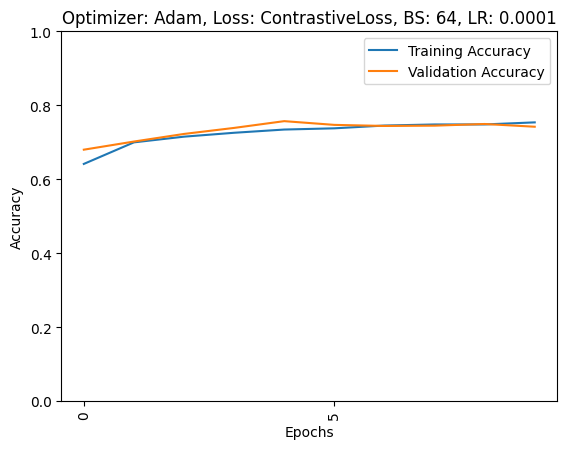

In [14]:
# Training the model
trainer = SiameseTrainer(model, train_dataset, val_datset, loss_function, BATCH_SIZE, EPOCHS, OPTIMIZER)

train_loss, validation_loss, train_accuracy, validation_accuracy = trainer.train_loop()
trainer.plot_losses(train_loss, validation_loss)
trainer.plot_accuracies(train_accuracy, validation_accuracy)